In [3]:
import sys
import os

# Add the root directory of your project to the Python path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "..")))


In [24]:
from xgboost import XGBClassifier
import sklearn
import numpy
import scipy
from binance.client import Client
from sklearn.model_selection import train_test_split
from bot.utils import load_config
import Feature_engineering
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import  cross_val_score
print("scikit-learn version:", sklearn.__version__)
print("NumPy version:", numpy.__version__)
print("SciPy version:", scipy.__version__)

scikit-learn version: 1.6.1
NumPy version: 2.2.6
SciPy version: 1.15.3


In [7]:
from bot.utils import load_config

config=load_config("../config/config.yaml")


# Connexion au client Binance
client = Client(config["api_key"], config["api_secret"])

import pandas as pd


klines = client.get_historical_klines(
    symbol=config["symbol"],
    interval=Client.KLINE_INTERVAL_15MINUTE,
    start_str="2022-01-01 00:00:00",
    end_str="2025-01-01 00:00:00"
)

# Conversion en DataFrame Pandas
columns = ["timestamp", "open", "high", "low", "close", "volume",
           "close_time", "quote_asset_volume", "number_of_trades",
           "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignore"]
df = pd.DataFrame(klines, columns=columns)

# Conversion du timestamp en format lisible
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

# Sélectionner uniquement les colonnes importantes
df = df[["timestamp", "open", "high", "low", "close", "volume"]]

# Afficher les 5 premières lignes
print(df.head())


            timestamp            open            high             low  \
0 2022-01-01 00:00:00  46216.93000000  46527.26000000  46208.37000000   
1 2022-01-01 00:15:00  46332.52000000  46421.27000000  46236.27000000   
2 2022-01-01 00:30:00  46375.42000000  46689.42000000  46360.19000000   
3 2022-01-01 00:45:00  46610.81000000  46731.39000000  46575.76000000   
4 2022-01-01 01:00:00  46656.14000000  46767.24000000  46574.06000000   

            close        volume  
0  46332.51000000  386.65709000  
1  46375.42000000  319.99973000  
2  46610.81000000  386.08077000  
3  46656.13000000  410.59336000  
4  46766.99000000  330.08774000  


In [8]:
df_max=Feature_engineering.prepare_features(df)

In [9]:
print(df_max.head())


            timestamp      open      high       low     close     volume  \
0 2022-01-01 08:15:00  47151.37  47344.69  47145.05  47305.23  183.98417   
1 2022-01-01 08:30:00  47305.23  47313.91  47166.97  47210.18  109.50519   
2 2022-01-01 08:45:00  47210.18  47260.00  47081.74  47124.82  107.04457   
3 2022-01-01 09:00:00  47124.82  47215.56  47062.77  47205.77  127.12603   
4 2022-01-01 09:15:00  47205.77  47205.78  47082.06  47094.74   85.76911   

         sma_14        ema_14        macd  macd_signal  ...  rolling_mean  \
0  47137.470714  47087.855730  131.563458   137.119650  ...  47137.470714   
1  47168.197857  47104.165633  130.061743   135.708068  ...  47168.197857   
2  47150.032857  47106.919548  120.593656   132.685186  ...  47150.032857   
3  47143.302143  47120.099609  118.258903   129.799929  ...  47143.302143   
4  47136.315714  47116.718327  106.224906   125.084925  ...  47136.315714   

   rolling_std  rolling_skew  rolling_kurt  close_lag1  close_lag2  \
0   165.56

In [33]:
print(df_max.columns)

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'sma_14',
       'ema_14', 'macd', 'macd_signal', 'macd_diff', 'rsi', 'stoch_k',
       'stoch_d', 'roc', 'atr', 'bollinger_mavg', 'bollinger_hband',
       'bollinger_lband', 'bollinger_width', 'obv', 'mfi', 'rolling_mean',
       'rolling_std', 'rolling_skew', 'rolling_kurt', 'close_lag1',
       'close_lag2', 'close_lag3', 'close_lag4', 'return_future', 'target'],
      dtype='object')


In [10]:
# Remove any columns you don't want as features (like "return_future" or raw "target" if present)
feature_cols = [col for col in df_max.columns if col not in ["target", "return_future","timestamp"]]
X = df_max[feature_cols]
y = df_max["target"]


In [11]:
# Split your full dataset into train and test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Then split X_train_full into actual training and validation set (80/20 again)


In [12]:
from xgboost import XGBClassifier
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    n_estimators=1000,         # max trees
    max_depth=6,               # reset to default
    learning_rate=0.05,
)

model.fit(
    X_train, y_train,
)

/Users/raph4/crypto-bot/crypto-bot/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, ...)

Accuracy: 0.5280
Classification Report:
              precision    recall  f1-score   support

    sell (0)       0.53      0.51      0.52     10455
     Buy (1)       0.53      0.54      0.54     10581

    accuracy                           0.53     21036
   macro avg       0.53      0.53      0.53     21036
weighted avg       0.53      0.53      0.53     21036



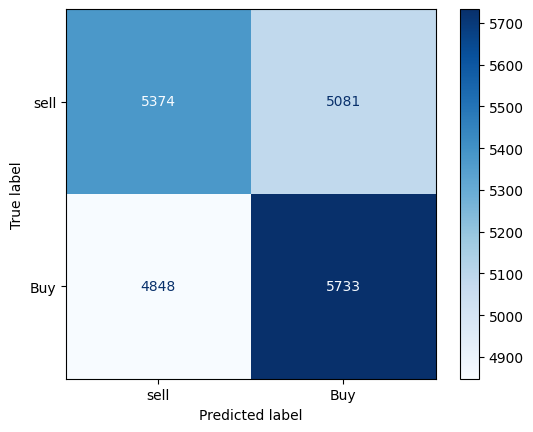

In [13]:
y_pred = model.predict(X_test)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["sell (0)", "Buy (1)"]))

# Optional: Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=["sell", "Buy"])
disp.plot(cmap="Blues")

/Users/raph4/crypto-bot/crypto-bot/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:06:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.5382
Classification Report:
              precision    recall  f1-score   support

    sell (0)       0.54      0.51      0.53     10455
     Buy (1)       0.54      0.56      0.55     10581

    accuracy                           0.54     21036
   macro avg       0.54      0.54      0.54     21036
weighted avg       0.54      0.54      0.54     21036



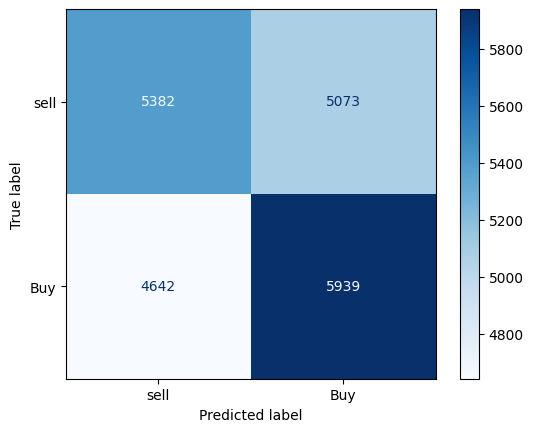

In [14]:
model2 = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    gamma=0.1,
    random_state=42,
    use_label_encoder=False
)
model2.fit(
    X_train, y_train,
)

y_pred = model2.predict(X_test)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["sell (0)", "Buy (1)"]))

# Optional: Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=["sell", "Buy"])
disp.plot(cmap="Blues")

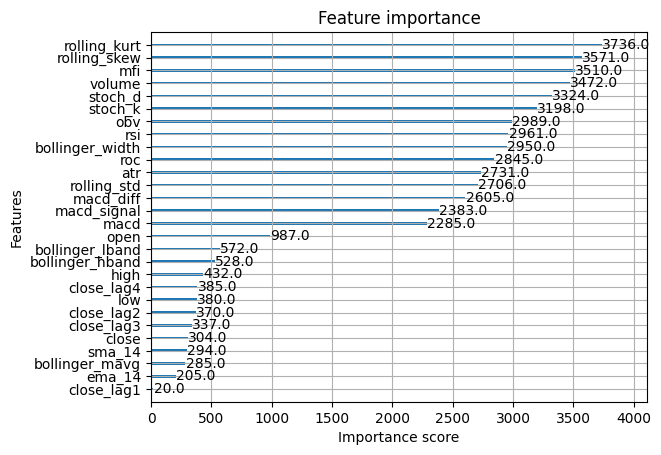

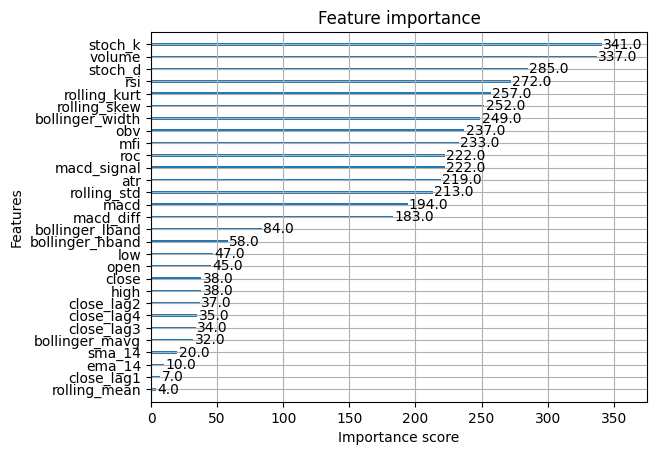

In [17]:
from xgboost import plot_importance
plot_importance(model, max_num_features=30)
plot_importance(model2, max_num_features=30)
plt.show()

In [23]:


# Use your full feature set
X = df_max.drop(columns=["target", "return_future","timestamp"], errors="ignore")
y = df_max["target"]

def objective(trial):
    # Suggest hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 80, 120),
        "max_depth": trial.suggest_int("max_depth", 3, 5),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.03, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 0.8),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.9, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 3, 7),
        "gamma": trial.suggest_float("gamma", 0.0, 0.2),
        "random_state": 42,
        "use_label_encoder": False,
        "eval_metric": "logloss",
        "objective": "binary:logistic"
    }

    # Model with current hyperparams
    model = XGBClassifier(**params)

    # Cross-validation for robust performance
    score = cross_val_score(model, X, y, cv=3, scoring="accuracy").mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, timeout=600)
print("Best Accuracy:", study.best_value)
print("Best Hyperparameters:", study.best_params)

[I 2025-06-03 16:43:26,503] A new study created in memory with name: no-name-16a66897-737c-4cae-8426-7037209b645f
/Users/raph4/crypto-bot/crypto-bot/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:43:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/raph4/crypto-bot/crypto-bot/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:43:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/raph4/crypto-bot/crypto-bot/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:43:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-06-03 16:43:27,007] Trial 0 finished with va

Best Accuracy: 0.5353876119651854
Best Hyperparameters: {'n_estimators': 97, 'max_depth': 3, 'learning_rate': 0.011740091000547747, 'subsample': 0.6105274311500477, 'colsample_bytree': 0.9762208758572544, 'min_child_weight': 6, 'gamma': 0.08168009726574428}


In [25]:
best_params = study.best_params
best_params.update({
    "random_state": 42,
    "use_label_encoder": False,
    "eval_metric": "logloss",
    "objective": "binary:logistic"
})

final_model = XGBClassifier(**best_params)
final_model.fit(X, y)

/Users/raph4/crypto-bot/crypto-bot/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:54:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9762208758572544, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=0.08168009726574428, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.011740091000547747,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=97, n_jobs=None,
              num_parallel_tree=None, ...)

In [31]:
import joblib
joblib.dump(final_model, "xgb_model_optuna.pkl")


['xgb_model_optuna.pkl']